In [ ]:
import pandas as pd

def analyze_data(file_path):
    try:
        # Read the file into a pandas DataFrame
        df = pd.read_csv('/content/train .csv')

        # Check for null values
        null_counts = df.isnull().sum()
        print("Null Value Counts:\n", null_counts)

        # Get rows with null values
        rows_with_nulls = df[df.isnull().any(axis=1)]
        print("\nRows with Null Values:\n", rows_with_nulls)


        # Check for duplicates
        duplicate_rows = df[df.duplicated()]
        print("\nDuplicate Rows:\n", duplicate_rows)


        duplicate_row_indices = df[df.duplicated()].index.tolist()

        if duplicate_row_indices:
            print("\nRow Numbers of Duplicate Rows:", duplicate_row_indices)

        null_row_indices = df[df.isnull().any(axis=1)].index.tolist()

        if null_row_indices:
            print("\nRow Numbers of Rows with Null Values:", null_row_indices)

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse the file '{file_path}'. Check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

analyze_data("train.csv")


Null Value Counts:
 ID       0
Tweet    0
Label    0
dtype: int64

Rows with Null Values:
 Empty DataFrame
Columns: [ID, Tweet, Label]
Index: []

Duplicate Rows:
 Empty DataFrame
Columns: [ID, Tweet, Label]
Index: []


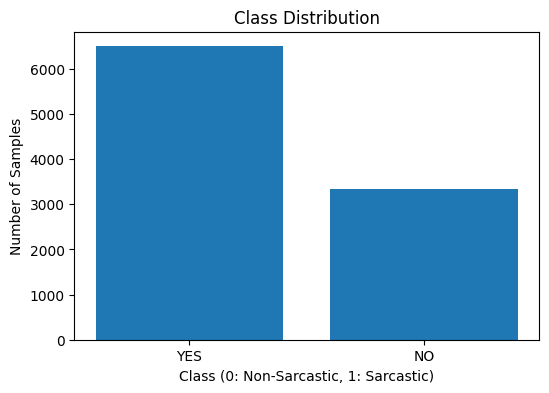

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your data
df = pd.read_csv("/content/train .csv")

# Count the occurrences of each class
class_counts = df['Label'].value_counts()

# Create the bar plot
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class (0: Non-Sarcastic, 1: Sarcastic)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()


Label
NO     6495
YES    6495
Name: count, dtype: int64


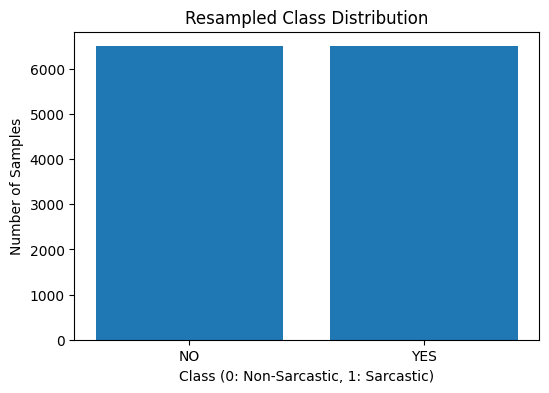

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Separate features (X) and target variable (y)
X = df.drop('Label', axis=1)  # Assuming 'Label' is your target column
y = df['Label']

# Choose either oversampling or undersampling
# --- Oversampling ---
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)



# Create a new DataFrame with the resampled data
df = pd.DataFrame(X_resampled, columns=X.columns)
df['Label'] = y_resampled

class_counts_resampled = df['Label'].value_counts()
print(class_counts_resampled)

# Plot the new class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_counts_resampled.index, class_counts_resampled.values)
plt.xlabel("Class (0: Non-Sarcastic, 1: Sarcastic)")
plt.ylabel("Number of Samples")
plt.title("Resampled Class Distribution")
plt.show()


In [ ]:
pip install ftfy emoji


In [ ]:
import pandas as pd
import re
import ftfy
import spacy

# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess_text_and_chunk(text):
    # 1. Fix encoding
    text = ftfy.fix_text(str(text))

    # 2. Lowercase
    text = text.lower()

    # 3. Remove empty quotes and special symbols
    text = re.sub(r'""|\*\*', '', text)
    text = re.sub(r'[""]', '', text)

    # 4. Replace hyphens
    text = re.sub(r'-', ' ', text)

    # 5. Remove URLs and paths
    text = re.sub(r'http[s]?://\S+|www\.\S+|/\S+', '', text)

    # 6. Remove @mentions
    text = re.sub(r'@[\w]+', '', text)

    # 7. Remove hashtags
    text = re.sub(r'#[\w]+', '', text)

    # 8. Keep only letters, numbers, spaces, and common punctuation
    # Updated regex to preserve more relevant information
    # includes numbers and common punctuation
    text = re.sub(r'[^\w\s.,!?;:]', '', text)

    # 9. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# === CONFIGURATION ===
input_csv = '/content/resampled_data.csv'  # Your input CSV
output_csv = 'pre-processed_with_chunks.csv'
text_column = 'Tweet'

# === PROCESSING ===
df = pd.read_csv(input_csv)

# Apply function
processed = df[text_column].apply(preprocess_text_and_chunk)

# Create new columns
df['cleaned_text'] = processed

# Save to CSV
df.to_csv(output_csv, index=False)

print(f"✅ Preprocessed and chunked data saved to: {output_csv}")

✅ Preprocessed and chunked data saved to: pre-processed_with_chunks.csv


In [ ]:
!python -m spacy download xx_ent_wiki_sm

In [ ]:

!python -m spacy download en_core_web_sm

In [ ]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

# Load English spaCy model for noun_chunks
nlp_en = spacy.load("en_core_web_sm")

# Load multilingual spaCy model for other tasks
nlp_xx = spacy.load("xx_ent_wiki_sm")

# === CONFIGURATION ===
input_file = "/content/pre-processed_with_chunks.csv"
output_file = "vectorized_output_multilingual.csv"
text_column = "cleaned_text"

# === LOAD CSV ===
df = pd.read_csv(input_file)

# Check if the specified column exists
if text_column not in df.columns:
    raise ValueError(f"Column '{text_column}' not found in the CSV.")

texts = df[text_column].fillna("").astype(str).tolist()

# === CHUNKING FUNCTION (Multilingual) ===
def extract_chunks(text):
    # Use en_core_web_sm for noun_chunks
    doc = nlp_en(text)
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]

    # Extract verb phrases (action-related phrases)
    verb_phrases = [" ".join([token.text for token in sent if token.pos_ == "VERB" or token.pos_ == "AUX"])
                    for sent in doc.sents]
    return " ".join(noun_chunks + verb_phrases)

# === APPLY CHUNKING ===
df["chunks"] = df[text_column].apply(extract_chunks)
chunk_texts = df["chunks"].fillna("").astype(str).tolist()

# === TF-IDF on BIGRAMS (original text) ===
tfidf_text_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=1000)
tfidf_text_features = tfidf_text_vectorizer.fit_transform(texts)
tfidf_text_df = pd.DataFrame(tfidf_text_features.toarray(), columns=[f"tfidf_bigram_{w}" for w in tfidf_text_vectorizer.get_feature_names_out()])

# === TF-IDF on CHUNKS (noun + verb phrases) ===
tfidf_chunk_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
tfidf_chunk_features = tfidf_chunk_vectorizer.fit_transform(chunk_texts)
tfidf_chunk_df = pd.DataFrame(tfidf_chunk_features.toarray(), columns=[f"tfidf_chunk_{w}" for w in tfidf_chunk_vectorizer.get_feature_names_out()])

# === SAVE VECTORIZED DATA ===
tfidf_text_df.to_pickle("tfidf_text_bigrams_multilingual.pkl")
tfidf_chunk_df.to_pickle("tfidf_chunked_phrases_multilingual.pkl")

# === MERGE + SAVE COMBINED ===
combined_df = pd.concat([df, tfidf_text_df, tfidf_chunk_df], axis=1)
combined_df.to_csv(output_file, index=False)

print(f"✅ TF-IDF bigrams + chunks (Multilingual) saved to: {output_file}")

✅ TF-IDF bigrams + chunks (Multilingual) saved to: vectorized_output_multilingual.csv


In [ ]:

import pandas as pd


from textblob import TextBlob

# Load the combined DataFrame
combined_df = pd.read_csv("/content/vectorized_output_multilingual.csv")

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply functions to get polarity and subjectivity for cleaned text
combined_df['polarity'] = combined_df['cleaned_text'].apply(get_polarity)
combined_df['subjectivity'] = combined_df['cleaned_text'].apply(get_subjectivity)

# Save the updated DataFrame
combined_df.to_csv("final_output.csv", index=False)
print("Polarity and subjectivity added to final_output.csv")


Polarity and subjectivity added to final_output.csv


In [ ]:
# prompt: print the column names of csv file

import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/final_output.csv')

# Print the column names
df.columns


Index(['ID', 'Tweet', 'Label', 'cleaned_text', 'chunks',
       'tfidf_bigram_aa gaya', 'tfidf_bigram_aa gayi', 'tfidf_bigram_aa raha',
       'tfidf_bigram_aa rahi', 'tfidf_bigram_aaj bhi',
       ...
       'tfidf_chunk_yeh', 'tfidf_chunk_yes5', 'tfidf_chunk_yesno',
       'tfidf_chunk_yogi', 'tfidf_chunk_you', 'tfidf_chunk_your',
       'tfidf_chunk_zindagi', 'tfidf_chunk_zyada', 'polarity', 'subjectivity'],
      dtype='object', length=2007)

In [ ]:
pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load your CSV file (replace with your file name)
df = pd.read_csv("/content/final_output.csv")  # Ensure it has a column "mbart_normalized"

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment contradiction (sarcasm-like features)
def sentiment_contradiction(text):
    sentiment = analyzer.polarity_scores(str(text))  # convert NaNs to string if any
    return {
        "neg_sarcasm_score": sentiment["neg"] * (1 - sentiment["compound"]),
        "pos_sarcasm_score": sentiment["pos"] * (1 + sentiment["compound"])
    }

# Apply function to each row
sentiment_features = df["cleaned_text"].apply(sentiment_contradiction)

# Convert result to a DataFrame
sentiment_df = pd.DataFrame(list(sentiment_features))

# Merge with original CSV
final_df = pd.concat([df, sentiment_df], axis=1)

# Save to new CSV file
final_df.to_csv("output_with_sarcasm_scores.csv", index=False)

print("✅ Done! Saved to 'output_with_sarcasm_scores.csv'")


✅ Done! Saved to 'output_with_sarcasm_scores.csv'


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack


df = pd.read_csv("output_with_sarcasm_scores.csv")

y = df["Label"].values


# 1. Sparse text features (BoW, TF-IDF, N-gram) — example: columns named bow_0, tfidf_23, ngram_45, etc.
sparse_columns = [col for col in df.columns if  col.startswith("tfidf_") ]
sparse_data = csr_matrix(df[sparse_columns].values)

# 2. Dense features (lexical + sentiment) — e.g., exclamation_count, avg_word_length, polarity, etc.
dense_columns = [ "polarity", "subjectivity",
                 "neg_sarcasm_score", "pos_sarcasm_score"]
dense_data = csr_matrix(df[dense_columns].values)

# 3. Combine both to get final feature matrix
X = hstack([sparse_data, dense_data])

print("✅ Final feature matrix shape:", X.shape)
print("✅ Labels shape:", y.shape)


✅ Final feature matrix shape: (12990, 2004)
✅ Labels shape: (12990,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(clf, "sarcasm_detector_model_classic.pkl")


              precision    recall  f1-score   support

          NO       0.95      0.98      0.96      1274
         YES       0.98      0.95      0.97      1324

    accuracy                           0.96      2598
   macro avg       0.97      0.97      0.96      2598
weighted avg       0.97      0.96      0.96      2598



['sarcasm_detector_model_classic.pkl']

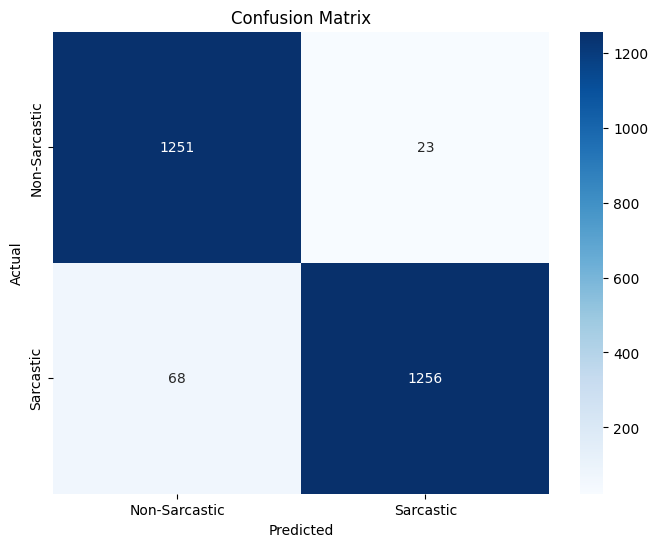

In [ ]:
# prompt: give confustion matrix for the above model?

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your model evaluation
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Sarcastic", "Sarcastic"],
            yticklabels=["Non-Sarcastic", "Sarcastic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import re
import ftfy
import emoji

def preprocess_text(text):
    # 1. Fix encoding
    text = ftfy.fix_text(str(text))

    # 2. Lowercase
    text = text.lower()

    # 3. Handle empty quotes and special characters like ""n **
    text = re.sub(r'""|\*\*', '', text)  # Escape * with backslashes
    text = re.sub(r'[""]', '', text)  # Remove any leftover quotes (optional)

    # 4. Replace hyphens (-) with spaces
    text = re.sub(r'-', ' ', text)  # Replace hyphen with space

    # 5. Extract emojis
    emoji_list = [char for char in text if emoji.is_emoji(char)]

    # 6. Remove emojis (optional)
    text = ''.join(char for char in text if not emoji.is_emoji(char))

    # 7. Replace multiple dots or question marks
    text = re.sub(r'\.{2,}', '.', text)    # Replace 2+ dots with one dot
    text = re.sub(r'\?{2,}', '?', text)    # Replace 2+ question marks with one

    # 8. Remove URLs (full URLs and partial paths starting with '/')
    text = re.sub(r'http[s]?://\S+|www\.\S+|/\S+', '', text)  # Remove both full and partial URLs

    # 9. Remove @username (mention handling)
    text = re.sub(r'@[\w]+', '', text)  # Remove words starting with @

    # 10. Remove #hashtag (hashtag handling)
    text = re.sub(r'#[\w]+', '', text)  # Remove words starting with #

    # 11. Remove special characters (allow only a-z, A-Z, @, #, and spaces)
    text = re.sub(r'[^a-zA-Z@#\s]', '', text)

    # 12. Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text, emoji_list


input_csv = '/content/train .csv'   # Replace with your CSV path
output_csv = 'preprocessed_data.csv'
text_column = 'Tweet'           # Change to the actual column name if different


df = pd.read_csv(input_csv)


df['cleaned_text'], df['emojis'] = zip(*df[text_column].map(preprocess_text))


df.to_csv(output_csv, index=False)

print(f"Preprocessed data saved to {output_csv}")


Preprocessed data saved to preprocessed_data.csv


In [ ]:
pip install indic-transliteration pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np

def generate_sarcasm_embeddings(csv_path, text_column='text', output_path='sarcasm_embeddings.csv'):
    """Generates sarcasm-aware embeddings for mixed English-Hinglish text"""
    try:
        # 1. Load Data
        df = pd.read_csv(csv_path)
        if text_column not in df.columns:
            print(f"Error: Column '{text_column}' not found.")
            return None

        # 2. Initialize Multilingual Sarcasm Model
        tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
        model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # 3. Process Texts in Batches
        embeddings = []
        for i in tqdm(range(0, len(df), 32), desc="Generating sarcasm embeddings"):
            batch = df[text_column].iloc[i:i+32].tolist()
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
            with torch.no_grad():
                outputs = model(**inputs)
                embeddings.append(outputs.last_hidden_state[:,0,:].cpu().numpy())

        # 4. Save Enhanced Embeddings
        emb_df = pd.DataFrame(np.vstack(embeddings), columns=[f'sarc_{i}' for i in range(768)])
        pd.concat([df, emb_df], axis=1).to_csv(output_path, index=False)
        print(f"Saved sarcasm embeddings to {output_path}")
        return True

    except Exception as e:
        print(f"Error: {str(e)}")
        return False

# Usage
generate_sarcasm_embeddings(
    csv_path="/content/preprocessed_data.csv",
    text_column="cleaned_text",  # Column with mixed English-Hinglish
    output_path="sarcasm_aware_embeddings.csv"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Generating sarcasm embeddings: 100%|██████████| 308/308 [25:34<00:00,  4.98s/it]


Saved sarcasm embeddings to sarcasm_aware_embeddings.csv


True

In [ ]:
from textblob import TextBlob
import pandas as pd

def add_sentiment_features(csv_path, text_column='cleaned_text', output_path='sarcasm_with_sentiment.csv'):
    df = pd.read_csv('/content/sarcasm_aware_embeddings.csv')

    # Extract sentiment features
    def extract_sentiment(text):
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        words = text.split()
        pos_words = sum(1 for word in words if TextBlob(word).sentiment.polarity > 0.3)
        neg_words = sum(1 for word in words if TextBlob(word).sentiment.polarity < -0.3)
        contrast = abs(polarity - (pos_words - neg_words) / max(len(words), 1))
        return pd.Series([polarity, subjectivity, pos_words, neg_words, contrast])

    df[['polarity', 'subjectivity', 'pos_words', 'neg_words', 'contrast']] = df[text_column].astype(str).apply(extract_sentiment)

    # Save combined embeddings + sentiment features
    df.to_csv(output_path, index=False)
    print(f"Saved combined features to: {output_path}")


In [ ]:
add_sentiment_features(
    csv_path="sarcasm_aware_embeddings.csv",
    text_column="cleaned_text",
    output_path="sarcasm_with_sentiment.csv"
)


Saved combined features to: sarcasm_with_sentiment.csv


In [ ]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv("/content/sarcasm_with_sentiment.csv")

# Identify label column (e.g., named "label")
y = df['Label'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0).values

# Drop non-feature columns (like text or id)
feature_cols = [col for col in df.columns if col.startswith('sarc_') or col in ['polarity', 'subjectivity', 'pos_words', 'neg_words', 'contrast']]
X = df[feature_cols].values


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(clf, "sarcasm_detector_model_balanced.pkl")


              precision    recall  f1-score   support

           0       0.88      0.98      0.92       672
           1       0.99      0.93      0.96      1296

    accuracy                           0.95      1968
   macro avg       0.93      0.95      0.94      1968
weighted avg       0.95      0.95      0.95      1968



['sarcasm_detector_model_balanced.pkl']

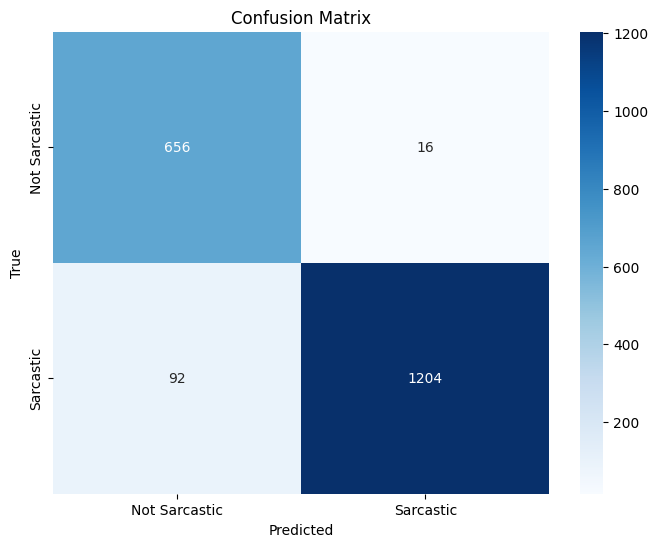

In [ ]:
# prompt: generate confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your previous code
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: Import "lime.lime_text" could not be resolved(reportMissingImports)
# .solve

!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2033bdc89376f5f3f424d51c87833c70e50f4b23f38b0d1d50fb0825bf551f10
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:


import pandas as pd
import re

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def analyze_and_preprocess(file_path, output_file):
    try:
        df = pd.read_csv(file_path)

        # Preprocess the text data in a specific column
        if 'Tweet' in df.columns:
            df['processed_text'] = df['Tweet'].apply(preprocess_text)
            df.to_csv(output_file, index=False)
            print(f"Preprocessed data saved to {output_file}")
        else:
            print("Error: 'text' column not found in the DataFrame.")



    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse the file '{file_path}'. Check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example Usage (replace with your file paths)
analyze_and_preprocess("/content/test.csv", "preprocessed_test_data.csv")


Preprocessed data saved to preprocessed_test_data.csv


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np

def generate_sarcasm_embeddings(csv_path, text_column='text', output_path='sarcasm_embeddings.csv'):
    """Generates sarcasm-aware embeddings for mixed English-Hinglish text"""
    try:
        # 1. Load Data
        df = pd.read_csv(csv_path)
        if text_column not in df.columns:
            print(f"Error: Column '{text_column}' not found.")
            return None

        # 2. Initialize Multilingual Sarcasm Model
        tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
        model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # 3. Process Texts in Batches
        embeddings = []
        for i in tqdm(range(0, len(df), 32), desc="Generating sarcasm embeddings"):
            batch = df[text_column].iloc[i:i+32].tolist()
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
            with torch.no_grad():
                outputs = model(**inputs)
                embeddings.append(outputs.last_hidden_state[:,0,:].cpu().numpy())

        # 4. Save Enhanced Embeddings
        emb_df = pd.DataFrame(np.vstack(embeddings), columns=[f'sarc_{i}' for i in range(768)])
        pd.concat([df, emb_df], axis=1).to_csv(output_path, index=False)
        print(f"Saved sarcasm embeddings to {output_path}")
        return True

    except Exception as e:
        print(f"Error: {str(e)}")
        return False

# Usage
generate_sarcasm_embeddings(
    csv_path="/content/preprocessed_test_data.csv",
    text_column="processed_text",  # Column with mixed English-Hinglish
    output_path="sarcasm_aware_embeddings_test.csv"
)

Generating sarcasm embeddings: 100%|██████████| 66/66 [06:01<00:00,  5.47s/it]


Saved sarcasm embeddings to sarcasm_aware_embeddings_test.csv


True

In [ ]:
from textblob import TextBlob
import pandas as pd

def add_sentiment_features(csv_path, text_column='processed_text', output_path='sarcasm_with_sentiment_test.csv'):
    df = pd.read_csv('/content/sarcasm_aware_embeddings_test.csv')

    # Extract sentiment features
    def extract_sentiment(text):
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        words = text.split()
        pos_words = sum(1 for word in words if TextBlob(word).sentiment.polarity > 0.3)
        neg_words = sum(1 for word in words if TextBlob(word).sentiment.polarity < -0.3)
        contrast = abs(polarity - (pos_words - neg_words) / max(len(words), 1))
        return pd.Series([polarity, subjectivity, pos_words, neg_words, contrast])

    df[['polarity', 'subjectivity', 'pos_words', 'neg_words', 'contrast']] = df[text_column].astype(str).apply(extract_sentiment)

    # Save combined embeddings + sentiment features
    df.to_csv(output_path, index=False)
    print(f"Saved combined features to: {output_path}")


In [ ]:
add_sentiment_features(
    csv_path='/content/sarcasm_aware_embeddings_test.csv',
    text_column="processed_text",
    output_path="sarcasm_with_sentiment_test.csv"
)


Saved combined features to: sarcasm_with_sentiment_test.csv


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

# 🔹 1. Load your enhanced CSV (with BERT + sentiment features)
df = pd.read_csv("sarcasm_with_sentiment_test.csv")  # Replace with your actual filename

# 🔹 2. Separate features and labels
X = df.drop(columns=["Label"])  # Drop the target
y = df['Label'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0).values # Ground truth labels
X = df.drop(columns=["ID"])
# 🔹 3. Drop any non-numeric columns (like tweet text or ID)
X = X.select_dtypes(include='number')

# 🔹 4. Load your trained model
model = joblib.load("/content/sarcasm_detector_model_balanced.pkl")

# 🔹 5. Predict using the model
y_pred = model.predict(X)

# 🔹 6. Classification report
print("📊 Classification Report:\n")
print(classification_report(y, y_pred, target_names=["Non-Sarcastic", "Sarcastic"]))

# 🔹 7. Add predictions to original DataFrame
df["Predicted_Label"] = y_pred

# 🔹 8. Save only selected columns: Label, Tweet, Prediction
df_to_save = df[["Label", "processed_text", "Predicted_Label"]]  # Replace 'processed_text' with 'tweet' if needed
df_to_save.to_csv("sarcasm_predictions_clean.csv", index=False)

print("\n✅ Clean predictions saved to 'sarcasm_predictions_clean.csv'")


📊 Classification Report:

               precision    recall  f1-score   support

Non-Sarcastic       0.89      0.99      0.94       706
    Sarcastic       0.99      0.94      0.96      1403

     accuracy                           0.95      2109
    macro avg       0.94      0.96      0.95      2109
 weighted avg       0.96      0.95      0.96      2109


✅ Clean predictions saved to 'sarcasm_predictions_clean.csv'


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
import joblib
import numpy as np
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModel
import torch
from lime.lime_text import LimeTextExplainer

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
bert_model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load trained model
model = joblib.load("/content/sarcasm_detector_model_balanced.pkl")

# Sentiment features
def extract_sentiment_features(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    words = text.split()
    positive_words = sum(1 for word in words if TextBlob(word).sentiment.polarity > 0.3)
    negative_words = sum(1 for word in words if TextBlob(word).sentiment.polarity < -0.3)
    sentiment_contrast = abs(polarity - (positive_words - negative_words) / max(len(words), 1))
    return np.array([polarity, subjectivity, positive_words, negative_words, sentiment_contrast])

# BERT embedding
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(bert_model.device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

# Wrapper for LIME
def predict_proba(texts):
    all_features = []
    for text in texts:
        bert_vec = get_bert_embedding(text)
        senti_vec = extract_sentiment_features(text)
        combined = np.hstack((bert_vec, senti_vec))
        all_features.append(combined)
    return model.predict_proba(np.array(all_features))

# ---------- INPUT ----------
input_text = input("📝 Enter a Hinglish sentence: ")

# Prediction
bert_vector = get_bert_embedding(input_text)
sentiment_vector = extract_sentiment_features(input_text)
final_input = np.hstack((bert_vector, sentiment_vector)).reshape(1, -1)

prediction = model.predict(final_input)[0]
probs = model.predict_proba(final_input)[0]

print("\n📌 Prediction:")
print(f"➡️ Sarcasm Probability: {probs[1]*100:.2f}%")
print(f"➡️ Non-Sarcasm Probability: {probs[0]*100:.2f}%")
print(f"✅ Final Prediction: {'Sarcastic' if prediction == 1 else 'Non-Sarcastic'}")

# ---------- LIME Explanation ----------
print("\n🔍 Word Contributions to Prediction:\n")

explainer = LimeTextExplainer(class_names=["non-sarcastic", "sarcastic"])
exp = explainer.explain_instance(input_text, predict_proba, num_features=10)

for word, weight in exp.as_list():
    direction = "🟢" if weight > 0 else "🔴"
    percent = abs(weight) * 100  # rough indicator
    print(f"{direction} {word}: {percent:.2f}% contribution")

# Optional: save explanation
exp.save_to_file("lime_explanation_input.html")



📌 Prediction:
➡️ Sarcasm Probability: 94.00%
➡️ Non-Sarcasm Probability: 6.00%
✅ Final Prediction: Sarcastic

🔍 Word Contributions to Prediction:

🟢 laugh: 5.20% contribution
🟢 didn: 4.38% contribution
🟢 that: 3.39% contribution
🟢 t: 3.33% contribution
🟢 joke: 3.05% contribution
🟢 funny: 2.83% contribution
🟢 was: 2.68% contribution
🟢 ah: 1.79% contribution
🔴 i: 1.53% contribution
🟢 get: 1.30% contribution
